# Exercise 4

## Instructions:

- All previous instructions hold.
- In addition, if you are using GPU, you must check that your code also runs on a CPU.
- **Make sure you use the best practices you learned in class**.

## Intro
In this exercise, you will implement Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) models that were introduced during the lecture and Recitation 10.
The goal is to gain hands-on experience with sequence models and understand how they process and generate sequential data.

In [1]:
!pip install rarfile

In [2]:
import os
import sys
import copy
import zipfile
import rarfile
import time
import random
import collections
import numpy as np
from PIL import Image
import pickle
import requests

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches


from google.colab import drive
from google.colab import files

# %matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

print(torch.__version__)

# %load_ext autoreload
# %autoreload 2

2.9.0+cpu


# Recurrent Neural Networks (40 points)

Understanding and implementing the RNN cell. As you learned in class, the RNN has a certain structure that allows it to accept the previous hidden state the current input, and output an hidden state and an output vector. The RNN cell uses the same weights for all time steps, much like convolution uses the same weights for all the batches in the image. Even though you already are familiar with PyTorch, implementing the RNN you make sure you understand how this pivotal architecture works.

## Helper functions

In [3]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

#  RNN: step forward (10 points)

First implement the function `rnn_step_forward` which implements the forward pass for a single timestep of a recurrent neural network. After doing so run the following to check your implementation. You should see errors less than 1e-7.

In [4]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """
    Run the forward pass for a single timestep of an RNN that uses a tanh
    activation function.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data for this timestep, of shape (N, D).
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    next_h, cache = None, None
    ##############################################################################
    # TODO: Implement a single forward step for the RNN. Store the next  #
    # hidden state and any values you need for the backward pass in the next_h   #
    # and cache variables respectively.                                          #
    ##############################################################################

    # Compute the next hidden state: h_t = tanh(x @ Wx + h_{t-1} @ Wh + b)
    next_h = np.tanh(x @ Wx + prev_h @ Wh + b)

    # Cache values needed for the backward pass
    cache = (x, prev_h, Wx, Wh, b, next_h)

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return next_h, cache

In [5]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


#RNN: step backward (10 points)

In [6]:
def rnn_step_backward(dnext_h, cache):
    """
    Backward pass for a single timestep of an RNN.

    Inputs:
    - dnext_h: Gradient of loss with respect to next hidden state
    - cache: Cache object from the forward pass

    Returns a tuple of:
    - dx: Gradients of input data, of shape (N, D)
    - dprev_h: Gradients of previous hidden state, of shape (N, H)
    - dWx: Gradients of input-to-hidden weights, of shape (D, H)
    - dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
    - db: Gradients of bias vector, of shape (H,)
    """
    dx, dprev_h, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a single step of a RNN.      #
    #                                                                            #
    # HINT: For the tanh function, you can compute the local derivative in terms #
    # of the output value from tanh.                                             #
    ##############################################################################

    # Unpack cache
    x, prev_h, Wx, Wh, b, next_h = cache

    # Backprop through tanh: d/dx tanh(x) = 1 - tanh²(x)
    dz = dnext_h * (1 - next_h ** 2)

    # Backprop through the linear operations
    dx = dz @ Wx.T          # (N, H) @ (H, D) -> (N, D)
    dprev_h = dz @ Wh.T     # (N, H) @ (H, H) -> (N, H)
    dWx = x.T @ dz          # (D, N) @ (N, H) -> (D, H)
    dWh = prev_h.T @ dz     # (H, N) @ (N, H) -> (H, H)
    db = np.sum(dz, axis=0) # sum over batch -> (H,)

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dprev_h, dWx, dWh, db

In [7]:
np.random.seed(1337)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.8730509825914645e-10
dprev_h error:  1.931634610323001e-08
dWx error:  6.586630396892865e-10
dWh error:  9.131820369191576e-10
db error:  8.569581669830872e-10


# RNN: forward (10 points)
Now that you have implemented the forward and backward passes for a single timestep of an RNN, you will combine these pieces to implement an RNN that process an entire sequence of data.

In [8]:
def rnn_forward(x, h0, Wx, Wh, b):
    """
    Run an RNN forward on an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the RNN forward, we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D).
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H).
    - cache: Values needed in the backward pass
    """
    h, cache = None, None
    ##############################################################################
    # TODO: Implement forward pass for a RNN running on a sequence of    #
    # input data. You should use the rnn_step_forward function that you defined  #
    # above. You can use a for loop to help compute the forward pass.            #
    ##############################################################################

    N, T, D = x.shape
    H = h0.shape[1]

    # Initialize output array and cache list
    h = np.zeros((N, T, H))
    cache = []

    # Start with initial hidden state
    prev_h = h0

    # Loop through each timestep
    for t in range(T):
        # Get input for current timestep
        x_t = x[:, t, :]
        # Forward pass for single timestep
        next_h, step_cache = rnn_step_forward(x_t, prev_h, Wx, Wh, b)
        # Store hidden state
        h[:, t, :] = next_h
        # Store cache for backward pass
        cache.append(step_cache)
        # Update hidden state for next timestep
        prev_h = next_h

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return h, cache

In [9]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466151011529e-08


# RNN: backward (10 points)

In [10]:
def rnn_backward(dh, cache):
    """
    Compute the backward pass for an RNN over an entire sequence of data.

    Inputs:
    - dh: Upstream gradients of all hidden states, of shape (N, T, H)

    Returns a tuple of:
    - dx: Gradient of inputs, of shape (N, T, D)
    - dh0: Gradient of initial hidden state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    - db: Gradient of biases, of shape (H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a RNN running an entire      #
    # sequence of data. You should use the rnn_step_backward function that you   #
    # defined above. You can use a for loop to help compute the backward pass.   #
    ##############################################################################

    # Get dimensions from the first cache entry
    x_0, _, Wx, _, _, _ = cache[0]
    N, T, H = dh.shape
    D = x_0.shape[1]

    # Initialize gradients
    dx = np.zeros((N, T, D))
    dWx = np.zeros_like(Wx)
    dWh = np.zeros((H, H))
    db = np.zeros(H)

    # Initialize the gradient flowing back from future timesteps
    dprev_h = np.zeros((N, H))

    # Backprop through time (reverse order)
    for t in reversed(range(T)):
        # Total gradient at timestep t = upstream gradient + gradient from future
        dh_total = dh[:, t, :] + dprev_h

        # Backward pass for single timestep
        dx_t, dprev_h, dWx_t, dWh_t, db_t = rnn_step_backward(dh_total, cache[t])

        # Store dx for this timestep
        dx[:, t, :] = dx_t

        # Accumulate gradients for shared weights
        dWx += dWx_t
        dWh += dWh_t
        db += db_t

    # The gradient of h0 is the dprev_h after processing t=0
    dh0 = dprev_h

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dh0, dWx, dWh, db

In [11]:
np.random.seed(1337)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.5571085568563326e-09
dh0 error:  5.423206039675471e-10
dWx error:  3.579829809212802e-09
dWh error:  7.994186410119177e-09
db error:  5.755566528286172e-10


## Questions

##**Question 1 :**
When using an RNN on long sequences, what could happen? What causes this to happen?   **(3 Points)**


---



your answer

The vanishing gradient problem occurs - gradients become extremely small as they backpropagate through many timesteps, making it hard for the network to learn long-term dependencies. This happens because we multiply gradients by the same weight matrix repeatedly, and if the values are less than 1, they shrink exponentially. The model essentially "forgets" information from early timesteps.

---



##**Question 2:**
Could this problem be solved by a different model? How does it accomplish this?   **(3 Points)**


---
your answer

Yes, LSTM networks solve this problem. They use a cell state with gating mechanisms (forget, input, output gates) that allow gradients to flow more easily through time without vanishing, and can selectively remember or forget information over long sequences.

---



##**Question 3:**
What does the hidden state represent intuitively?  **(4 Points)**


---
your answer

The hidden state is like a "memory" or "summary" of all the information the network has seen so far in the sequence. It encodes the relevant context from previous timesteps that the model needs to make predictions about future timesteps.

---

# Building Image Captioning in PyTorch (50 points)

- The goal of image captioning is to describe a given image using natural language.
- Using neural networks, we can partition the problem into 2 separate challenges.
1. We need to extract meaningful features regarding the image that would help us describe it.
2. We need to generate a sequence of words that best fit those features. Luckily, the flexability of neural networks allows us to take a CNN architecture and connect it directly to a LSTM network. We only need to provide proper labels to train the new network we created.

- For this exercise, you will be provided with pretrained networks for both feature extraction and sentence generation, and you will connect the different components needed to make image captioning work.

- First, we define the feature extractor and the recurrent model seperately. The feature extractor takes an image and produces a vector representation of the image features. As those features hold information about the image, we will use that vector as the input for our recurrent model. The RNN will produce the image captioning using an LSTM architecture.

In [12]:
# Please upload the folder to your drive and adjust the path if necessary.
drive.mount('/content/drive')
my_path = '/content/drive/MyDrive/deep_hw4/deep_hw4'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
rarfile.UNRAR_TOOL = "/usr/bin/unrar"  # Ensure the unrar tool is installed

In [15]:
# unzipping the pretrained models
# with zipfile.ZipFile(os.path.join('models', 'pretrained_model.zip'), 'r') as zip_ref:
#     zip_ref.extractall('models')

# Define paths
rar_parts = [f'{my_path}/models/models.part0{i}.rar' for i in range(1, 10)]  # Adjust range as needed
output_dir = 'models'

# Check if all parts exist
missing_parts = [part for part in rar_parts if not os.path.exists(part)]
if missing_parts:
    print(f"Error: Missing parts: {', '.join(missing_parts)}")
else:
    try:
        # Open the first part and extract all files
        with rarfile.RarFile(rar_parts[0], 'r') as rf:
            rf.extractall(output_dir)
            print(f"Extracted all files to '{output_dir}' successfully.")
    except rarfile.Error as e:
        print(f"An error occurred while extracting the RAR files: {e}")


Extracted all files to 'models' successfully.


In [16]:
# unzipping vocabulary
with zipfile.ZipFile(os.path.join(my_path, 'data/vocab.zip'), 'r') as zip_ref:
    zip_ref.extractall('data')

In [17]:
conv_path = 'models/encoder-5-3000.pkl'
lstm_path = 'models/decoder-5-3000.pkl'
vocab_path   = 'data/vocab.pkl'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the following code to check if all the files are in place
print("conv_path ", '✓' if os.path.isfile(conv_path) == True else '✗')
print("lstm_path ", '✓' if os.path.isfile(lstm_path) == True else '✗')
print("vocab_path ", '✓' if os.path.isfile(vocab_path) == True else '✗')

conv_path  ✓
lstm_path  ✓
vocab_path  ✓


## Implementing image captioning model **(40 points)**.

As training a multimodal classifier could take some time and resources, we spared you the training phase this time ⏳.

In this exercise, we use a pretrained model to solve the image captioning task. Using pretrained models is a common practice in the deep learning community and it's important to be aware of such techniques to save time and energy.


In previous cells, we unzipped the necessary files, but in order to be able to load the models (and then use them) it is required to build the same PyTorch model as the pretrained model.

- **ConvNet architecture:** resnet152 (without last fc layer) -> fc layer -> BatchNorm1d

- **LSTM architecture:** LSTM -> linear -> embed

We added more detailed instructions in the next cells, please make sure you follow them carefully.

**Please make sure you construct your models based on the sizes we provided.**

In [18]:
embed_size   = 256      # dimension of word embedding vectors
hidden_size  = 512      # dimension of lstm hidden states
num_layers   = 1        # number of layers in lstm

In [19]:
class ConvNet(nn.Module):
    def __init__(self, embed_size):
        super(ConvNet, self).__init__()
        resnet = models.resnet152() # construct an nn.Sequential model without the last resnet152 layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # make sure you define each of the None parameters
        self.linear = None
        self.bn = None
        #############################################################################
        # TO DO:                                                                    #
        # create a new sequential model which includes the resnet and               #
        # add a new fully connected layer that outputs a vector with the size of    #
        # the wanted embedding. Next, you should add a batchnorm layer with         #
        # momentum=0.01 (BatchNorm1d parameter).                                    #
        # This function has no return value.                                        #
        #############################################################################

        # ResNet152 output: 2048 features after global average pooling
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # perdefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training. Make sure you are inputing a correct shape       #
        # to the batchnorm layer.                                                   #
        # This function returns the features of the image.                          #
        #############################################################################

        # Freeze ResNet weights - don't compute gradients for pretrained network
        with torch.no_grad():
            features = self.resnet(images)

        # Flatten: (N, 2048, 1, 1) -> (N, 2048)
        features = features.reshape(features.size(0), -1)

        # Pass through linear layer and batch normalization
        features = self.bn(self.linear(features))

        return features

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################




class LSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(LSTM, self).__init__()
        self.max_seg_length = max_seq_length
        self.embed = None
        self.lstm = None
        self.linear = None
        #############################################################################
        # TO DO:                                                                    #
        # Define the hyper-parameters and the layers of the pretrained LSTM.        #
        # Create an Embedding layer that accepts the output of the                  #
        # feature extractor.  Next, the built-in LSTM architecture in PyTorch.nn    #
        # with the proper inputs (use the built-in documentation tool in Jupyter    #
        # or just look at the official documentation online).                       #
        # Define an additional linear layer that comes after the LSTM and outputs   #
        # a vector that will support the size of our vocabulary.                    #
        # This function has no return value.                                        #
        #############################################################################

        # Embedding layer: vocab_size -> embed_size
        self.embed = nn.Embedding(vocab_size, embed_size)

        # LSTM layer: input_size=embed_size, hidden_size=hidden_size
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        # Linear layer: hidden_size -> vocab_size (to predict next word)
        self.linear = nn.Linear(hidden_size, vocab_size)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        #############################################################################
        # TO DO:                                                                    #
        # Generate captions for a given image features.                             #
        # First, obtain the output of the LSTM network.        #
        # Next, use the hidden states to obtain the most probable word and store    #
        # all the word predictions in the sampled_ids list. Don't forget to update  #
        # the inputs for each timestep to continue making predictions based on the  #
        # words you are alreaedy predicted.                                         #
        # Make sure you keep track of the dimensions of the inputs and outputs,     #
        # since PyTorch expects tensors with a batch dimension. You can use the     #
        # methods .squeeze() and .unsqueeze()                                       #
        # This function returns the list of predicted words.                        #
        #############################################################################

        for i in range(self.max_seg_length):
            # Pass through LSTM: inputs shape (N, 1, embed_size)
            hiddens, states = self.lstm(inputs, states)

            # Pass through linear layer to get word scores: (N, 1, vocab_size)
            outputs = self.linear(hiddens.squeeze(1))  # (N, vocab_size)

            # Get the most probable word (greedy decoding)
            _, predicted = outputs.max(1)  # (N,)

            # Store the predicted word
            sampled_ids.append(predicted)

            # Embed the predicted word for the next timestep
            inputs = self.embed(predicted)  # (N, embed_size)
            inputs = inputs.unsqueeze(1)    # (N, 1, embed_size)

        # Stack all predictions: list of (N,) -> (N, max_seq_length)
        sampled_ids = torch.stack(sampled_ids, 1)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

        return sampled_ids

In [20]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.Resampling.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

In [22]:
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

#### Unleash your creativity! 💫

Choose an image that really gets your imagination going! Let's try to wow Ron with some funny pictures that will make the homework checking process a whole lot more enjoyable! 🤩


In [23]:
# Build models
conv = ConvNet(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
lstm = LSTM(embed_size, hidden_size, len(vocab), num_layers)
conv = conv.to(device)
lstm = lstm.to(device)

# Load the trained model parameters
conv.load_state_dict(torch.load(conv_path))
lstm.load_state_dict(torch.load(lstm_path))

# Prepare an image
image_path = os.path.join(my_path, 'data/pic2.jpg')
image = load_image(image_path, transform)
image_tensor = image.to(device)

<start> a person holding a glass of wine in a vase . <end>


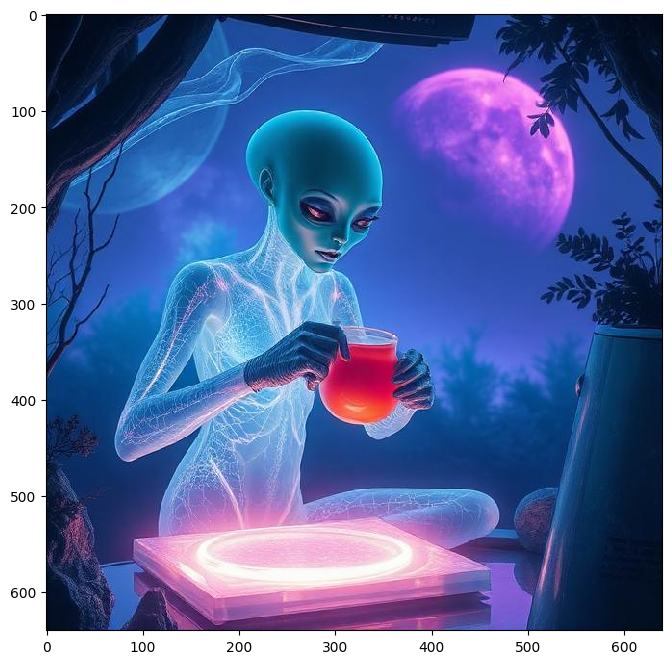

In [24]:
# Generate an caption from the image
# Important Note - this piece of code may not work for all implementations. You may need to adjust it a bit so it
# will produce the desired output (image + caption)
feature = conv(image_tensor)
sampled_ids = lstm.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print(sentence)
image = Image.open(image_path)
plt.imshow(np.asarray(image));

## Questions

##**Question 4:**
Could you think of scenarios where the model fails? Why would that happen? give at least 4 resones **(4 Points)**

We encourage you to test it on different images (jpg).



---
your answer

1. Rare or unseen objects - if the image contains objects not well-represented in training data, the model won't describe them correctly
2. Complex scenes - images with many objects or unusual compositions confuse the model
3. Abstract concepts - the model can't understand emotions, humor, or context that requires reasoning
4. Different image styles - drawings, cartoons, or artistic images that differ from natural photos in the training set

---


##**Question 5:**
Provide one example of a good caption and one that the model didn't manage to work well with. **(1 Point)**




---
your answer

Good: A standard photo of a dog sitting on grass → "a small dog is holding a frisbee in its mouth"

Bad: A bioluminescent alien scientist with translucent skin and glowing veins is calmly brewing tea inside a floating crystal laboratory orbiting a distant purple planet → "a person holding a cake with a candle on it"

---

##**Question 6:**
What happens if the forget gate is always close to zero? Close to one? **(2 Points)**



---
your answer

If the forget gate is close to zero, the cell state is constantly being erased, so the LSTM can't maintain long-term memory and behaves more like a regular RNN. If it's close to one, the model never forgets anything, which can cause it to accumulate irrelevant information and fail to adapt to new inputs.

---

##**Question 7:**
How does the LSTM mitigate the vanishing gradient problem? **(3 Points)**



---
your answer

The LSTM uses an additive cell state instead of multiplicative hidden state updates, which creates a "highway" for gradients to flow backward without shrinking. The forget gate controls how much old information to keep, allowing gradients to pass through many timesteps almost unchanged when needed.

---